# 1. Introducción
Tras haber obtenido los datos y procesarlos, pasamos a visualizarlos y hacer algunos análisis a partir únicamente de ellos.

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import nolds 
import antropy as ant

from pathlib import Path
from scipy.stats import norm
from sklearn.decomposition import PCA
from numpy.fft import rfft, irfft
from statsmodels.tsa.stattools import acf

TICKER_TARGET = 'AMD'

/Users/jenriquezafra/Proyectos/Dev/python/Chaos_Signals/.venv/lib/python3.12/site-packages/nolds/datasets.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
import sys, os
print("PY:", sys.executable)

PY: /Users/jenriquezafra/Proyectos/Dev/python/Chaos_Signals/.venv/bin/python


---
# 2. Carga de datos
Obtenemos los datos procesados.

In [3]:
# obtenemos la ruta
dir_path = Path('../data').resolve()
path = dir_path / 'processed'
dfs = {}

# obtenemos todos los files y los metemos en un diccionario
for file in path.iterdir():
    if file.suffix == ".parquet":
        name = file.stem.split("_")[0]
        dfs[name] = pd.read_parquet(file, engine='pyarrow')


In [4]:
# accedemos a uno para comprobar
print(dfs['AMD'].head())

                               close       high        low       open  \
date                                                                    
2022-08-23 00:00:00+02:00  92.489998  94.440002  92.110001  92.389999   
2022-08-24 00:00:00+02:00  92.730003  93.379997  90.900002  92.209999   
2022-08-25 00:00:00+02:00  97.180000  97.570000  93.139999  93.139999   
2022-08-26 00:00:00+02:00  91.180000  97.599998  91.120003  96.290001   
2022-08-29 00:00:00+02:00  88.489998  91.190002  88.260002  90.050003   

                             volume  daily_return  log_return     range  \
date                                                                      
2022-08-23 00:00:00+02:00  52927000     -0.003770   -0.003777  2.330002   
2022-08-24 00:00:00+02:00  56520400      0.002595    0.002592  2.479996   
2022-08-25 00:00:00+02:00  61016200      0.047989    0.046873  4.430000   
2022-08-26 00:00:00+02:00  65552500     -0.061741   -0.063729  6.479996   
2022-08-29 00:00:00+02:00  61142500   

---
# 3. Análisis univariado
Vamos a estudiar las series temporales de precios y volumen, histogramas de returns, y boxplots para ver outliers.

## 3.1. Series temporales

In [5]:
fig_close = go.Figure()

for name, df in dfs.items():
    fig_close.add_trace(
        go.Scatter(
            x=df.index,
            y=df['close'],
            mode='lines',
            name=name,
        )
    )

fig_close.update_layout(title='Precio al cierre', xaxis_title='Date', yaxis_title='Open')
fig_close.show()

In [6]:
fig_ret = go.Figure()

for name, df in dfs.items():
    fig_ret.add_trace(
        go.Scatter(
            x=df.index,
            y=df['daily_return'],
            mode='lines',
            name=name,
        )
    )

fig_ret.update_layout(title='Daily Return ', xaxis_title='Date', yaxis_title='Return')
fig_ret.show()

Esta visualización tiene como ventaja que todo está normalizado. En precios algunas son mucho más grandes que otras y no se ven bien. 

El daily_return nos permite ver épocas de volatilidad.

In [7]:
fig_vol = go.Figure()

for name, df in dfs.items():
    fig_vol.add_trace(
        go.Scatter(
            x=df.index,
            y=df['volume'],
            mode='lines',
            name=name,
        )
    )

fig_vol.update_layout(title='Volúmenes ', xaxis_title='Date', yaxis_title='Volume')
fig_vol.show()

## 3.2. Histogramas
Haremos de daily_return, de rango, volúmenes y un log-return vs. normal gaussiana (opcional)

In [8]:
fig_hist_ret = go.Figure()

for name, df in dfs.items():
    fig_hist_ret.add_trace(
        go.Histogram(
            x=df['daily_return']*100, # convertimos a porcentaje
            name=name,
            opacity=0.6,
        )
    )

fig_hist_ret.update_layout(
    title='Daily Return histogram',
    xaxis_title='Daily Return [%]', 
    yaxis_title='Count')

fig_hist_ret.show()

In [9]:
fig_hist_vol = go.Figure()

for name, df in dfs.items():
    fig_hist_vol.add_trace(
        go.Histogram(
            x=df['volume'],
            name=name,
            opacity=0.6,
        )
    )

fig_hist_vol.update_layout(
    title='Volume histogram',
    xaxis_title='Volume', 
    yaxis_title='Count',
    )

fig_hist_vol.show()

Para los log_returns, por ahora lo haré para un solo stock,

In [10]:
df_target = dfs[TICKER_TARGET]
log_returns = df_target['log_return']

# creamos la normal de referencia ajustada a nuestros datos
mu = log_returns.mean()
sigma = log_returns.std()
x = np.linspace(log_returns.min(), log_returns.max(), 200)
pdf = norm.pdf(x, mu, sigma)

# hacmeos el gráfico
fig_log_ret = go.Figure()

fig_log_ret.add_trace(
    go.Histogram(
        x=log_returns,
        histnorm='probability density',
        name='Log Returns',
        opacity=0.6,
    )
)

# añadimos la normal de referencia
fig_log_ret.add_trace(
    go.Scatter(
        x=x,
        y=pdf,
        mode='lines',
        name='Normal Distribution',
        line=dict(color='red', width=2)
    )
)

fig_log_ret.update_layout(
    title=f'Log Returns Distribution with Normal Fit [{TICKER_TARGET}]',
    xaxis_title='Log Returns',
    yaxis_title='Probability Density',
    legend=dict(x=0.01, y=0.99, traceorder='normal', orientation='h')
)

fig_log_ret.show()


- En este caso vemos que están muy concentrados alrededor de 0 (lo esperado).

- Pico más alto en el 0 (en general retornos bajos)

- Colas más grandes que la gaussiana (mayores eventos extremos)

- Asimetría: parece cola hacia la izquierda (negativa)

## 3.3. Boxplots
Se deja para más adelante. Ahora no es relevante.

---
# 4. Análisis multivariado

## 4.1. Correlaciones
Vemos matriz de correlación de retornos, heatmap y correlación rolling (ventanas de 60-90 días) entre pares relevantes.
Aquí voy a empezar a tomar como target a AMD y comparar con peers. Concretamente contra NVDA (lead), MSFT (tech), y QQQ (benchmark).

In [11]:
# hacemos un df con los retornos logarítmicos de todos los activos
log_returns = pd.concat(
    {ticker: dfs[ticker]['log_return'] for ticker in dfs.keys()},
    axis=1
)

# matriz de correlación
corr = log_returns.corr()

fig = go.Figure(
    data=go.Heatmap(
        z=corr.values,
        x=corr.columns,
        y=corr.index,
        colorscale='RdBu',
        zmin=-1, zmax=1,
#        text=np.round(corr.values, 2),
#        texttemplate="%{text}",
#        textfont={"size":14},
        colorbar=dict(title='Correlation')
    )
)

# layout
fig.update_layout(
    title='Matriz de correlación de log-returns',
    width=600, height=600
)
fig.show()

Esto permite ver rápidamente los tickers más importantes. Los FX son insignificantes; de las commodities solo afecta un poco el cobre (HG=F); las tech e índices son todos son importantes. El que más correlación tiene es el índice SOXX (semiconductores), y el que tiene más correlación inversa es VIX (volatilidad).

In [12]:
target = TICKER_TARGET
peers  = ["NVDA","INTC", "MSFT", "QQQ", "SOXX", "SMH", "TSM", "^VIX"]
window = 20  # usa 5 para 1 semana, 20 para ~1 mes

logrets = pd.concat(
    {t: dfs[t]["log_return"].rename(t) for t in [target] + peers},
    axis=1
).dropna(how="all")

# --- Calcular rolling correlations AMD vs cada peer ---
rollcorr = pd.DataFrame(index=logrets.index)
for p in peers:
    # alinear y calcular correlación móvil
    rollcorr[f"{target} vs {p}"] = (
        logrets[target]
        .rolling(window)
        .corr(logrets[p])
    )

rollcorr = rollcorr.dropna(how="all")

# hacemos la gráfica
fig = go.Figure()

for col in rollcorr.columns:
    fig.add_trace(go.Scatter(
        x=rollcorr.index,
        y=rollcorr[col],
        mode="lines",
        name=col
    ))

# línea horizontal en 0 para referencia
fig.add_hline(y=0, line_width=1, line_dash="dash", opacity=0.6)

fig.update_layout(
    title=f"Rolling correlation de log-returns — {target} vs peers (ventana={window})",
    xaxis_title="Fecha",
    yaxis_title="Correlación",
    yaxis=dict(range=[-1, 1]),
    legend_title="Pares",
    width=900, height=450
)

fig.show()

Aquí podemos ver la correlación promediada a 20 días. Se puede ver que hay momentos en los que se invierten las correlaciones: correlaciones que deberían ser altas son nulas o incluso negativas; y correlaciones negativas pasan a ser positivas.

Creo que son días de alta volatilidad (^VIX). Debería mirar mejor estos cambios de régime, pueden ser origen de señales al unirlo a métricas caóticas.

## 4.2. Análisis de dimensionalidad
PCA sobre retornos. Scatter de PC1 vs. PC2. Loadings de cada activo en cada componente.

In [13]:
# vamos con sklearn porque es más rápido que con numpy
# como no entrenamos ahora ningún modelo, da igual que incluyamos el target (AMD)
logrets = log_returns.reset_index(drop=True).dropna()

pca = PCA(n_components=3)
logrets_pca = pca.fit_transform(logrets)

print("Varianza explicada:", pca.explained_variance_ratio_)
print("Varianza acumulada:", pca.explained_variance_ratio_.cumsum())

Varianza explicada: [0.59552841 0.128986   0.06131974]
Varianza acumulada: [0.59552841 0.72451441 0.78583416]


/Users/jenriquezafra/Proyectos/Dev/python/Chaos_Signals/.venv/lib/python3.12/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning:

divide by zero encountered in matmul

/Users/jenriquezafra/Proyectos/Dev/python/Chaos_Signals/.venv/lib/python3.12/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning:

overflow encountered in matmul

/Users/jenriquezafra/Proyectos/Dev/python/Chaos_Signals/.venv/lib/python3.12/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning:

invalid value encountered in matmul



Esto nos dice que con tomar las 3 primeras componentes podemos explicar el 78% de la varianza de nuestro sistema.

Podemos ver también qué sotck tiene más peso en cada componente principal.

In [14]:
# vemos las cargas
loadings = pd.DataFrame(pca.components_.T,
                        index=logrets.columns,
                        columns=[f'PC{i+1}' for i in range(3)])

loadings.head(15)

PC1       PC2       PC3
INTC     -0.196691  0.153652 -0.025168
NVDA     -0.268575  0.371282  0.033297
QQQ      -0.136121  0.110670 -0.018226
TWD=X    -0.001764 -0.004094 -0.000195
AMZN     -0.158845  0.136579 -0.059810
META     -0.169023  0.212199 -0.181437
GOOGL    -0.129619  0.128288 -0.048731
SPY      -0.105224  0.047933  0.006225
JPY=X    -0.001019 -0.003551 -0.009297
SMH      -0.208486  0.241341  0.031103
AMD      -0.244123  0.405999 -0.062167
MSFT     -0.117947  0.126327 -0.060758
SOXX     -0.210318  0.234395  0.028054
EURUSD=X  0.000233  0.000793 -0.011116
CL=F     -0.033651  0.029452  0.695651

Vemos que para la primera componente es el factor mercado, y explica casi el 60% de la varianza.

La segunda componente, de un 13%, es el factor del sector de semiconductores.

La tercera solo tiene un 6% del total, y parace que está dominado por el precio del petróleo.

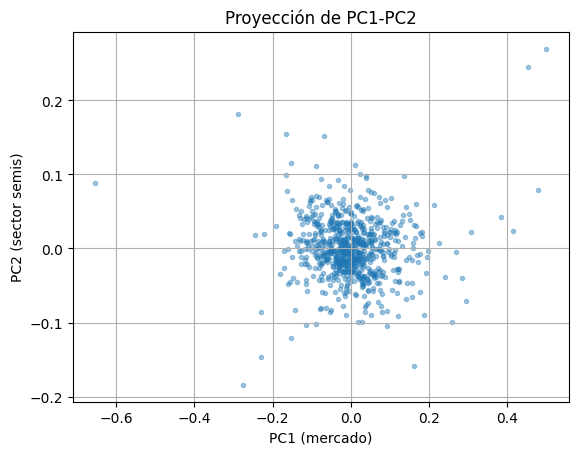

In [15]:
plt.scatter(logrets_pca[:, 0], logrets_pca[:, 1], alpha=0.4, marker='.')
plt.xlabel("PC1 (mercado)")
plt.ylabel("PC2 (sector semis)")
plt.title("Proyección de PC1-PC2")
plt.grid()
plt.show()

ANALISIS??

## 4.3. Relaciones no lineales
Haremos 3 partes. Un delay plots (espacio de fases simple); autocorrelación y PACF; y algunas métricas caóticas simples: exponente de Hurst y entropía de permutación.

### 4.3.1 Delay plot
Vamos a graficar la serie contra una copia retrasada de sí misma: $x_t$ vs $x_{t-\tau}$,
donde $x_t$ serña el log-return y $\tau$ el retardo que queramos. Para esto, primero tenemos que hallar un retardo óptimo. Yo usaré cuando la función de correlación toca el 0,

In [16]:
# primero tenemos que hallar un retardo óptimo, yo usaré cuando la autocorrelación se anula
r = log_returns[TICKER_TARGET].dropna()
r = (r-r.mean())        # centramos
N = len(r)

crit = 1.96/np.sqrt(N)  # nivel de significación 95%
acf_vals = acf(r.values, nlags=30, adjusted=True, fft=True)

def pick_tau_from_acf(acf_vals, crit):
    a = np.asarray(acf_vals[1:], float)  # ignoramos el lag 0
    lags = np.arange(1, len(acf_vals))
    # buscamos el primer cruce de cero
    sign = np.sign(a)
    idx = np.where((sign[:-1] > 0) & (sign[1:] <= 0))[0]
    if len(idx) == 0:
        return int(lags[idx[0]+1])  # si no cruza, devolvemos el máximo
    
    # primer minimo local
    for k in range(1, len(a)-1):
        if a[k] < a[k-1] and a[k] < a[k+1]:
            return int(lags[k])
        
    # primer lago no significativo
    for k in range(len(a)):
        if abs(a[k]) < crit:
            return int(lags[k])
        
    # si no se cumple nada, devolvemos 1
    return 1

tau_ret = pick_tau_from_acf(acf_vals, crit)
print(f"Retardo óptimo para log-returns {TICKER_TARGET}:", tau_ret)


Retardo óptimo para log-returns AMD: 4


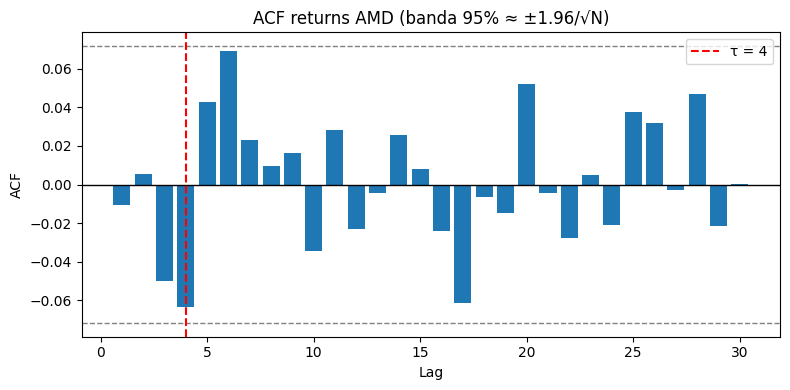

In [17]:
# lo representamos para verlo mejor, pero es opcional
lags = np.arange(len(acf_vals))

plt.figure(figsize=(8,4))
plt.bar(lags[1:], acf_vals[1:], width=0.8, align='center')

plt.axhline(0, color='k', lw=1)
plt.axhline( crit, color='gray', ls='--', lw=1)
plt.axhline(-crit, color='gray', ls='--', lw=1)
plt.axvline(tau_ret, color='r', ls='--', lw=1.5, label=f'τ = {tau_ret}')

plt.title(f'ACF returns {TICKER_TARGET} (banda 95% ≈ ±1.96/√N)')
plt.xlabel('Lag'); plt.ylabel('ACF'); plt.legend(); plt.tight_layout()
plt.show()

Esto implica que la memoria lineal de los retornos de AMD dura aproximadamente 4 días.

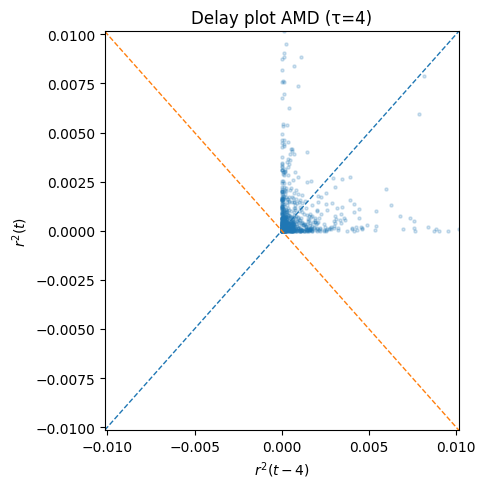

In [18]:
def delay_df(x:pd.DataFrame, tau:int):
    return pd.DataFrame({'x_t': x, 'x_tau': x.shift(tau)}).dropna()



df_tau = delay_df(r, tau=tau_ret)

plt.figure(figsize=(5,5))
plt.scatter(df_tau['x_tau']**2, df_tau['x_t']**2, s=5, alpha=0.2)
lim = np.percentile(np.abs(df_tau.values)**2, 99)

plt.plot([-lim, lim], [-lim, lim], '--', lw=1)
plt.plot([-lim, lim], [ lim,-lim], '--', lw=1)
plt.xlim(-lim, lim); plt.ylim(-lim, lim)

plt.xlabel(f'$r^2(t-{tau_ret})$'); plt.ylabel('$r^2(t)$')
plt.title(f'Delay plot {TICKER_TARGET} (τ={tau_ret})')
plt.tight_layout()
plt.show()

Con esto vemos la volatilidad ($r^2$). ANALIZAR MAS

### 4.3.2. Exponente de Hurst 
Voy a hallarlo para 3 ventanas diferentes: una semana (5d), dos semanas (10d) y un mes (20d). Solo para el target.

In [19]:
# usamos de nuevo los retornos logarítmicos (r)

df_target['hurst_5d'] = r.rolling(window=5).apply(lambda x: nolds.hurst_rs(x), raw=True)
df_target['hurst_10d'] = r.rolling(window=10).apply(lambda x: nolds.hurst_rs(x), raw=True)
df_target['hurst_20d'] = r.rolling(window=20).apply(lambda x: nolds.hurst_rs(x), raw=True)


/Users/jenriquezafra/Proyectos/Dev/python/Chaos_Signals/.venv/lib/python3.12/site-packages/nolds/measures.py:51: RuntimeWarning:

RANSAC did not reach consensus, using numpy's polyfit

/Users/jenriquezafra/Proyectos/Dev/python/Chaos_Signals/.venv/lib/python3.12/site-packages/nolds/measures.py:51: RuntimeWarning:

RANSAC did not reach consensus, using numpy's polyfit

/Users/jenriquezafra/Proyectos/Dev/python/Chaos_Signals/.venv/lib/python3.12/site-packages/nolds/measures.py:51: RuntimeWarning:

RANSAC did not reach consensus, using numpy's polyfit

/Users/jenriquezafra/Proyectos/Dev/python/Chaos_Signals/.venv/lib/python3.12/site-packages/nolds/measures.py:51: RuntimeWarning:

RANSAC did not reach consensus, using numpy's polyfit

/Users/jenriquezafra/Proyectos/Dev/python/Chaos_Signals/.venv/lib/python3.12/site-packages/nolds/measures.py:51: RuntimeWarning:

RANSAC did not reach consensus, using numpy's polyfit

/Users/jenriquezafra/Proyectos/Dev/python/Chaos_Signals/.venv/lib/python3.1

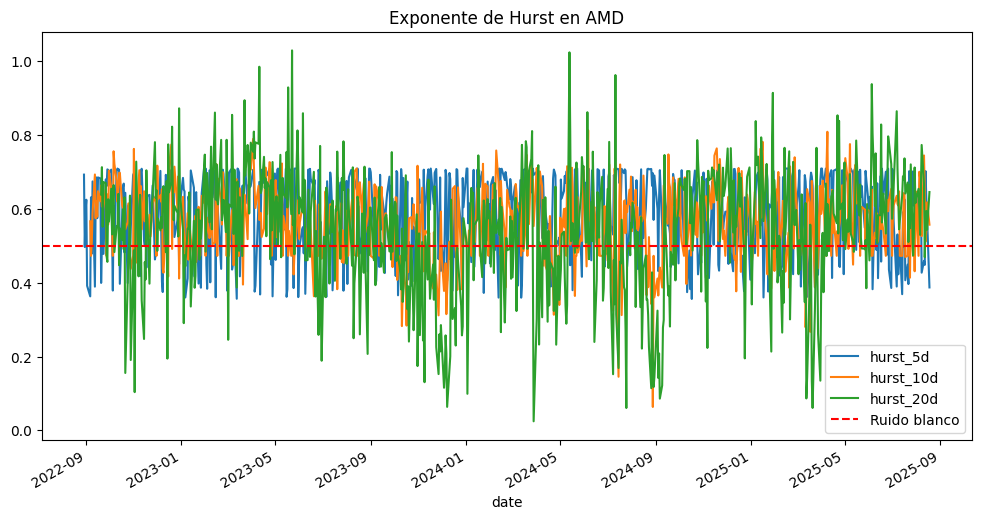

In [20]:
# lo representamos
df_target[["hurst_5d", "hurst_10d", "hurst_20d"]].plot(figsize=(12,6))
plt.axhline(0.5, color="red", linestyle="--", label="Ruido blanco")
plt.title(f"Exponente de Hurst en {TICKER_TARGET}")
plt.legend()
plt.show()

Por la interpretación del exponente de Hurst, creo que un buen criterio inicial podría ser:
- **(+1)** si al menos dos ventanas dan $H>0.60$ -> estrategia de *trend-follow*
- **(-1)** si al menos dos ventanas dan $H<0.40$ -> estrategia de *mean-reversion*
- **0** en otro caso

### 4.3.3. Entropía de permutación


In [21]:
df_target['perm_ent_40d'] = r.rolling(window=40).apply(lambda x: ant.perm_entropy(x, order=3, delay=1, normalize=True))
df_target['perm_ent_63d'] = r.rolling(window=63).apply(lambda x: ant.perm_entropy(x, order=3, delay=1, normalize=True))
df_target['perm_ent_84d'] = r.rolling(window=84).apply(lambda x: ant.perm_entropy(x, order=3, delay=1, normalize=True))

# lo representamos
df_target[["perm_ent_5d", "perm_ent_10d", "perm_ent_20d"]].plot(figsize=(12,6))
plt.title(f"Entropía de permutación en {TICKER_TARGET}")
plt.legend()
plt.grid()
plt.show()

KeyError: "None of [Index(['perm_ent_5d', 'perm_ent_10d', 'perm_ent_20d'], dtype='object')] are in the [columns]"

Tomamos esas ventanas tan grandes porque al tomar $m=3$ tenemos $m!=6$ patrones, e idealmente la longitud de cada ventana debe ser $L>5m!=30$. Tomamos $\tau=1$ ya que es lo típico en intradía.

Sobre la interpretación, recordar que 0 es dinámica totalmente determinista (periódica) y que 1 es ruido blanco prácticamente.

### 4.3.4. Exponentes de Lyapunov
Lo hallaremos con el método de Rosenstein (*nolds*):

In [ ]:
lyap = nolds.lyap_r(r.values, emb_dim=6, lag=tau_ret, min_tsep=10, fit='RANSAC')
print("LCE máximo:", lyap)

LCE máximo: -0.000391817771585237
